## Numerical Solution for the Heat Conductance Equation
<br/>

### Notebook Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import ticker
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import sympy as sp
import attrs
from heat_solver import HeatSolver


### **Problem Definition**

This assignment explores solution of the heat conductance equation, to model the temperature distribution along a thin, solid, homogeneous bar, which is insulated along its length.
$$
    \frac{\partial^2T}{\partial x^2} = \frac{1}{k}\frac{\partial T}{\partial{t}}
$$

The bar has length $L=100\text{ cm}$, and is smade for aluminum giving a value of $k = 0.875\text{ cm}^2\text{s}^{-1}$. <br/>
The boundry conditions are:
\begin{align}
T(x, 0) &= 500^{\circ}\text{C}\\
T(0, t) = T(L, t) &= 0^{\circ}\text{C}\\
\end{align}


We are intrested in the first $t_\text{total} = 600\text{ s}$
A time-space grid with $\Delta x = 20\text{ cm}$ and $\Delta t = 100\text{ s}$.
<br/><br/>

**Analytical solution**

The following is the analytcal solution for the heat conductance equation, which can be used as a reference 
$$
    T(x,t) = \frac{2000}{\pi}\sum_{\substack{n=1 \\ n\ \text{odd}}}^{\infty}\frac{1}{n}\sin\frac{n\pi x}{L}e^{-\frac{n^2\pi^2k}{L^2}t}
$$

### Explicit Soultion
<br/>

**Substitute finite difference approximations of derivatives into PDE**

Let $T_{i,j} = T(x_{i}, t_{i})$ as shorthand. Here the central difference is used for the positional derivative since we have boundry conditions at both ends of the rod. For the time derivative we use a forward difference.
$$
\begin{align}
\frac{\partial^2{T_{i,j}}}{\partial x^2} &= \frac{T_{i+1,j} - 2T_{i,j} + T_{i-1,j}}{\Delta x^2} \\
\frac{\partial{T_{i,j}}}{\partial t} &= \frac{T_{i,j+1} - T_{i,j}}{\Delta t}
\end{align}
$$
Substituting into the PDE gives
$$
\frac{T_{i+1,j} - 2T_{i,j} + T_{i-1,j}}{\Delta x^2} = \frac{1}{k} \frac{T_{i,j+1} - T_{i,j}}{\Delta t} \\
T_{i,j+1} = \frac{k\Delta t}{\Delta x^2}(T_{i+1,j} + (\frac{\Delta x^2}{k\Delta t} - 2)T_{i,j} + T_{i-1,j})
$$

**Temperature distribution along the bar at $100\ \text s$ intervals**

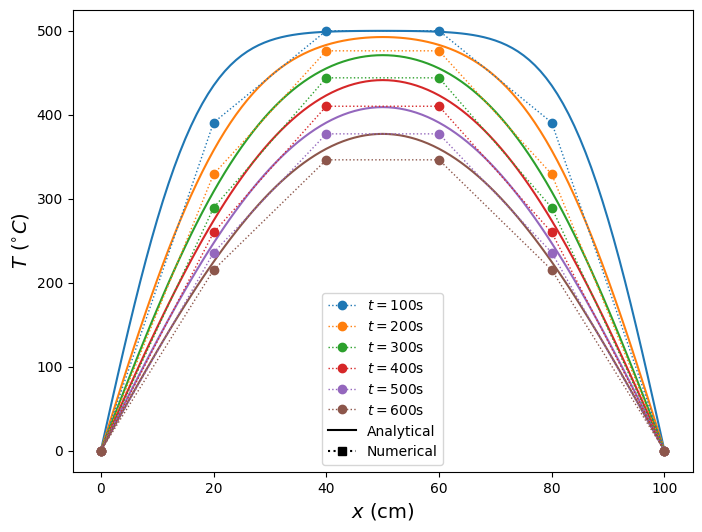

In [2]:
def T_distribution_at_t(t: np.float32, fig_path: str = None, solver=HeatSolver.solve_finite_distance) -> None:
  fig, ax = plt.subplots(1, figsize=(8, 6))

  hs = HeatSolver(dx=20, dt=100)
  T = solver(hs)

  hss: HeatSolver = attrs.evolve(hs, dx=1, dt=100)
  Ta = hss.solve_analytic()

  colors = []
  for Ts in Ta[1:]:
    line, = ax.plot(hss.xs, Ts)
    colors.append(line.get_color())
  for Ts, t, c in zip(T[1:], hs.ts[1:], colors):
    ax.plot(hs.xs, Ts, ":o", label=f"$t={int(t)}$s", color=c, linewidth=1.0)

  custom_lines = [
    # Continuous line
    Line2D([0], [0], color='black', linestyle='-'),
    # Approximation
    Line2D([0], [0], color='black', linestyle=':', marker='s')
  ]

  handles, labels = ax.get_legend_handles_labels()
  handles.extend(custom_lines)
  labels.extend(['Analytical', 'Numerical'])

  ax.legend(handles, labels, loc='best')
  ax.set_xlabel("$x$ (cm)", fontsize=14)
  ax.set_ylabel(r"$T$ ($^{\circ} C$)", fontsize=14)
  
  if fig_path:
    fig.savefig(fig_path)
  
T_distribution_at_t(100.0, "figs/p1_1.svg")

**Plot the evolution of temperature with time at $x = 20 \text{ cm}$, including the analytical solution to enable calculation of the error**

([215.18503548577428, 219.21655997886566, -3161.111831665039],
 224.7821063370456)

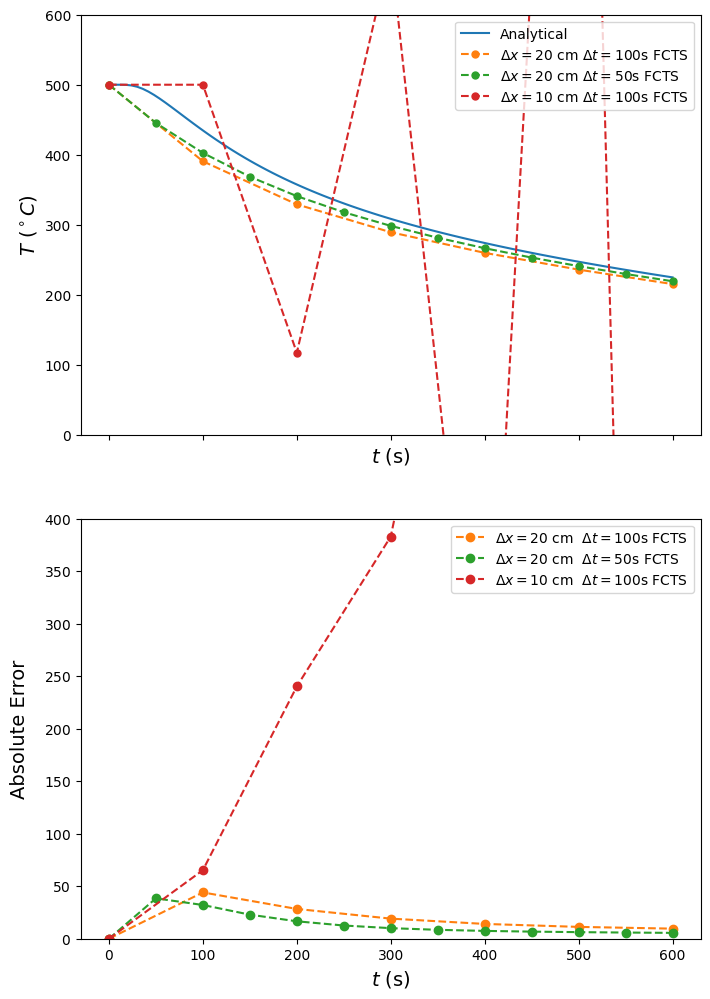

In [3]:
def plot_T_distribution_at_x(x: np.float32, dxdts: list, fig_path: str = None, solvers = {"finite distance": HeatSolver.solve_finite_distance}) -> None:
	fig1, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(8, 12))
	
	ax2.yaxis.set_major_formatter(lambda x, pos: rf"$\ \ ${int(x)}")
	
	def add_T_on_t_at_x(x: float, dx: float, dt: float, name: str, solver) -> int:
		hs = HeatSolver(dx=dx, dt=dt)
		T = solver(hs)
		ix = int(x/dx)
		Tx = T[:,ix]
		Txa = hs.solve_analytic()[:,ix]
		
		line, = ax1.plot(hs.ts, Tx, "--o", ms=5, label=rf"$\Delta x = {dx}$ cm $\Delta t = {dt:>3}$s {name}")
		c = line.get_color()
		
		error = np.abs(Tx - Txa)
		ax2.plot(hs.ts, error, "--o", label=rf"$\Delta x = {dx}$ cm  $\Delta t = {dt}$s {name}", color=c)
		return Tx[-1]

	hs = HeatSolver(dx=x, dt=None)
	hs.dt = hs.t_total / 100.0
	Txa = hs.solve_analytic()[:,1]
	ax1.plot(hs.ts, Txa, "", label="Analytical")
	
	ax1.set_ylabel(r"$T$ ($^\circ C$)", fontsize=14)
	ax1.set_xlabel("$t$ (s)", fontsize=14)
	ax1.set_ylim((0,600))
	ax2.set_ylabel("Absolute Error", fontsize=14)
	ax2.set_xlabel("$t$ (s)", fontsize=14)
	ax2.set_ylim((0,400))
	
	table = [add_T_on_t_at_x(x, dx, dt, name, solver) for name, solver in solvers.items() for dx, dt in dxdts]
	
	ax1.legend()
	ax2.legend()
	fig1.savefig(fig_path) 
	
	return table, Txa[-1]
  
plot_T_distribution_at_x(20, [(20, 100), (20, 50), (10, 100)], "figs/p1_2.svg", {"FCTS":HeatSolver.solve_finite_distance})

**3D plot with $\Delta x = 5 \text{cm}$ and $\Delta t = 10 \text{s}$**

In [4]:
def _3d_plot(ax, fig, X, T, T_xt, zlabel="", show_cbar=True, **kwargs):
  fig.tight_layout()
  ax.spines["top"].set_visible(False)
  ax.spines["bottom"].set_visible(False)
  ax.spines["left"].set_visible(False)
  ax.spines["right"].set_visible(False)
  ax.set_xticks([])
  ax.set_yticks([])
  
  ax = fig.add_subplot(projection='3d')  
  surf = ax.plot_surface(T, X, T_xt, antialiased=True,linewidth=0.5, edgecolor='black', **kwargs)
  if show_cbar:
	  fig.colorbar(surf, shrink=0.4, aspect=10, location="right", pad=0.1)
  
  ax.set_ylabel(r'$𝑥\ $(cm)', fontsize=16)
  ax.set_xlabel(r'$t\ $(s)', fontsize=16)
  ax.set_zlabel(zlabel, fontsize=16)
  
  return fig, ax

Mean   Error: 3.7291279845376986 +/- 5.773543044963896
Median Error: 2.9904856148526164


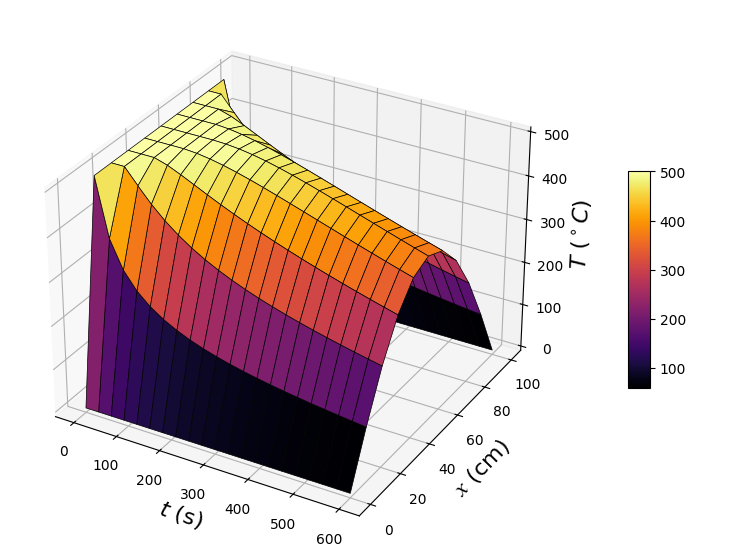

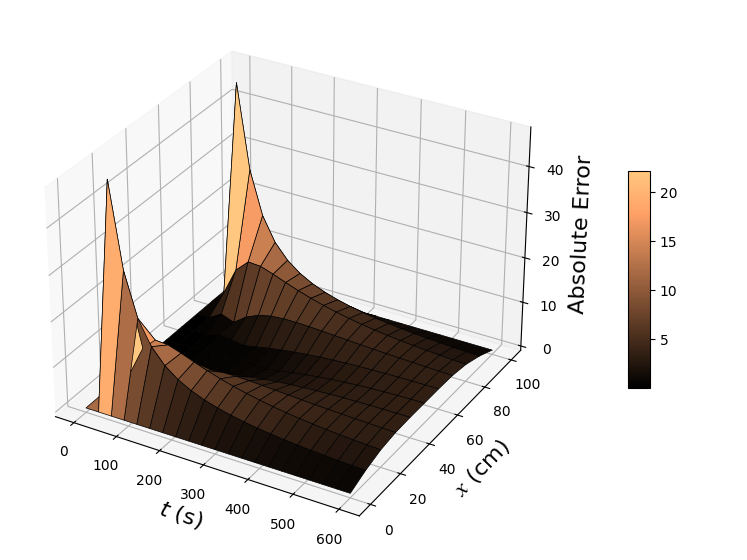

In [5]:
def p1_3d(dx: np.float32, dt: np.float32, fig_path: str = None):
  if fig_path:
    path, dot = fig_path.split(".")
    fig_path = [f"{path}a.{dot}", f"{path}b.{dot}"]
    
  hs = HeatSolver(dx=dx, dt=dt)
  T = hs.solve_finite_distance()
  ts, xs = np.meshgrid(hs.ts, hs.xs)

  fig, ax = plt.subplots(1, figsize=(8, 6))
  _3d_plot(ax, fig, xs, ts, T.T, zlabel=r"$T\ (^\circ C)$", cmap=cm.inferno)
  if fig_path:
    fig.savefig(fig_path[0]) 

  Ta = hs.solve_analytic()

  err = np.abs(Ta - T)
  fig, ax = plt.subplots(1, figsize=(8, 6))
  print(f"Mean   Error: {np.mean(err)} +/- {np.std(err)}")
  print(f"Median Error: {np.median(err)}")
  _3d_plot(ax, fig, xs, ts, err.T, zlabel="Absolute Error", cmap=cm.copper)
  
  if fig_path:
    fig.savefig(fig_path[1])
  
p1_3d(10, 30, "figs/p1_3.svg")

### Implicit Soultion: Crank-Nicholson Method

$$
\begin{align}
\frac{\partial T}{\partial t}\bigg\rvert_{i,j+\frac 1 2} &= \frac{T_{i,j+1} - T_{i,j}}{\Delta t} \\
\frac{\partial^2 T}{\partial x^2}\bigg\rvert_{i,j+\frac 1 2} &= \frac{1}{2\Delta x^2}(T_{i-1,j} - 2T_{i,j} + T_{i+1,j} + T_{i-1,j+1} - 2T_{i,j+1} + T_{i+1,j+1})
\end{align}
$$
Subsitituting into
$$
\frac{\partial^2 T}{\partial x^2}\bigg\rvert_{i,j+\frac 1 2} = \frac 1 k\frac{\partial T}{\partial t}\bigg\rvert_{i,j+\frac 1 2}
$$
Gives
$$
\frac{1}{2\Delta x^2}(T_{i-1,j} - 2T_{i,j} + T_{i+1,j} + T_{i-1,j+1} - 2T_{i,j+1} + T_{i+1,j+1}) = \frac{T_{i,j+1} - T_{i,j}}{k\Delta t}
$$

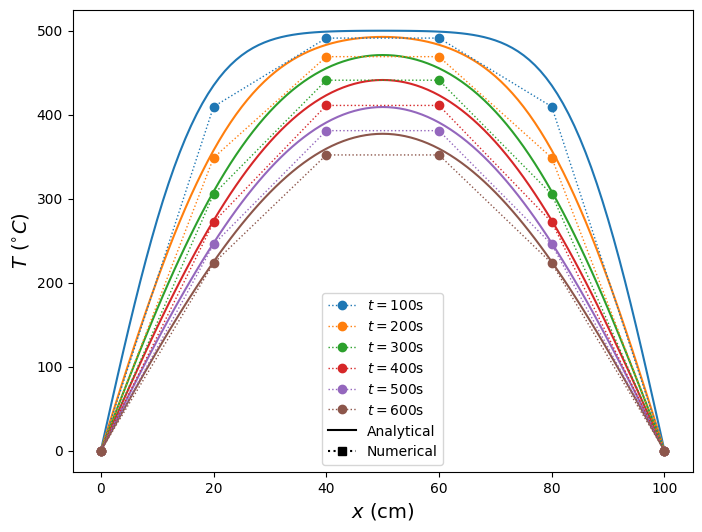

In [6]:
T_distribution_at_t(100.0, "figs/p2_1.svg", solver=HeatSolver.solve_crank_nicholson)

([215.18503548577428,
  219.21655997886566,
  -3161.111831665039,
  223.11878403522138,
  223.48085705704477,
  223.9171706085657],
 224.7821063370456)

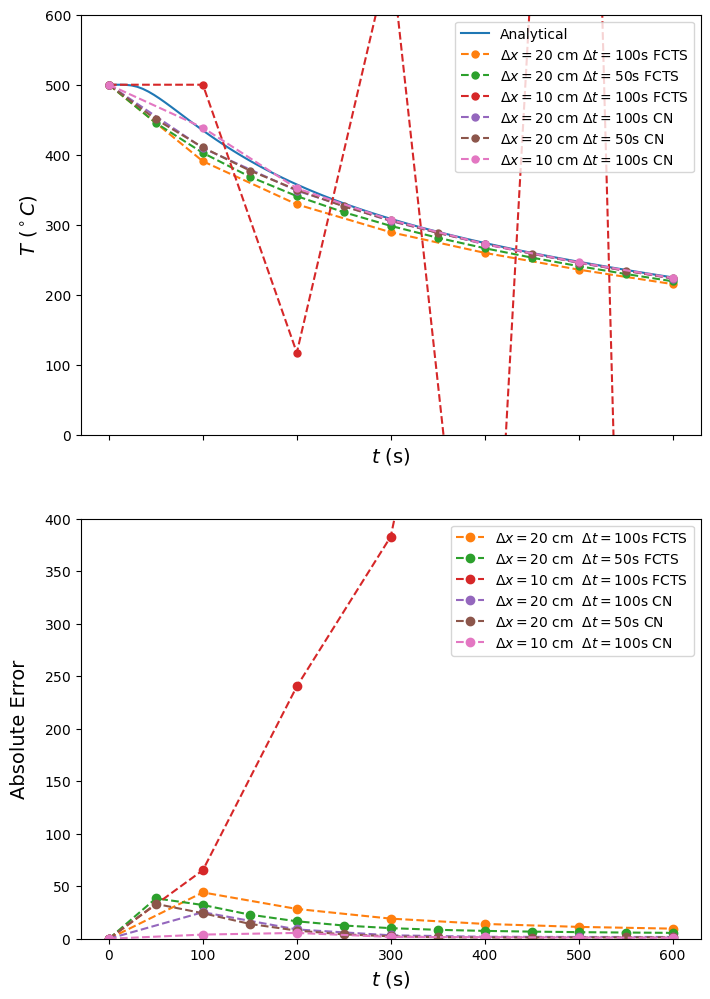

In [7]:
plot_T_distribution_at_x(20, [(20, 100), (20, 50), (10, 100)], "figs/p2_2.svg", {"FCTS":HeatSolver.solve_finite_distance, "CN":HeatSolver.solve_crank_nicholson})

Mean   Error: 1.8330613593004677 +/- 2.6725085084396665
Median Error: 0.9614917695670613


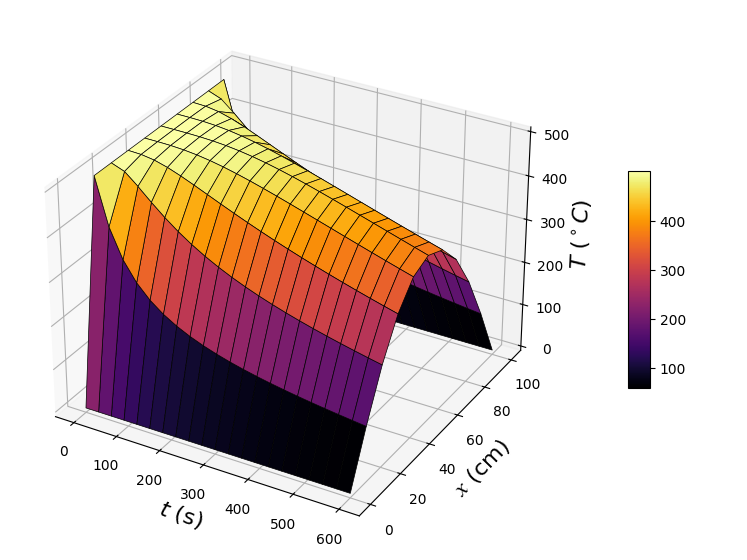

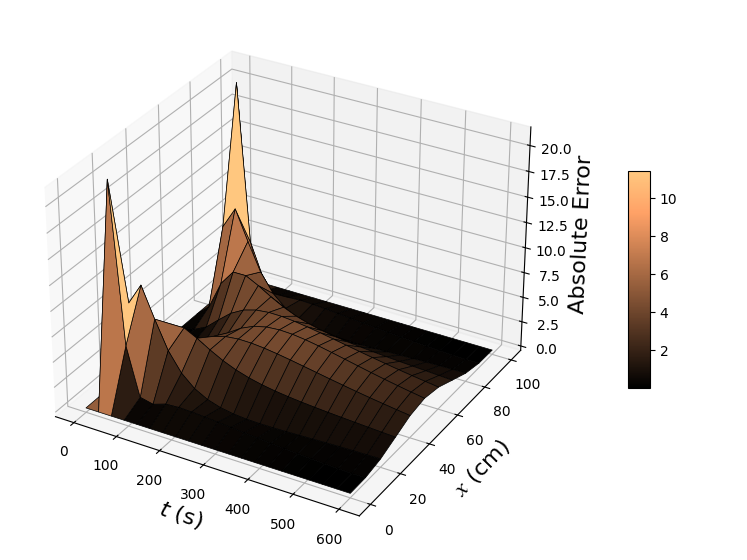

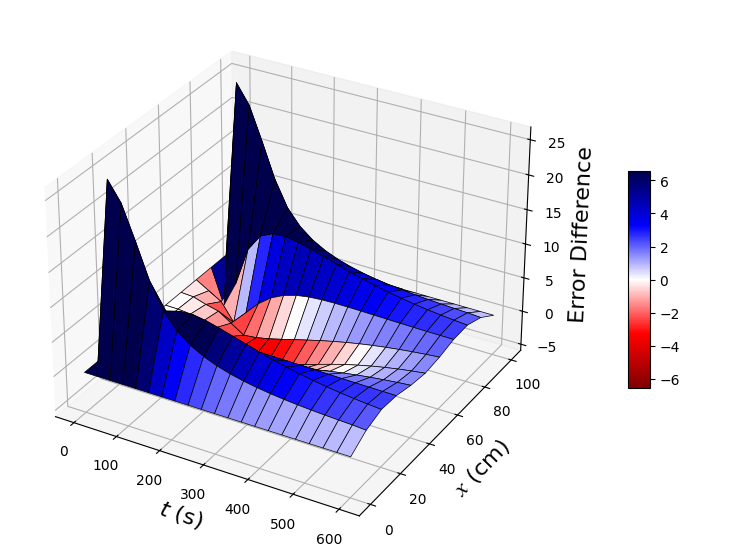

In [8]:
def p2_3d(dx: np.float32, dt: np.float32, fig_path: str = None):
  if fig_path:
    path, dot = fig_path.split(".")
    fig_path = [f"{path}a.{dot}", f"{path}b.{dot}", f"{path}c.{dot}"]
    
  hs = HeatSolver(dx, dt)
  T_cn = hs.solve_crank_nicholson()
  ts, xs = np.meshgrid(hs.ts, hs.xs)

  fig, ax = plt.subplots(1, figsize=(8, 6))
  _3d_plot(ax, fig, xs, ts, T_cn.T, zlabel=r"$T\ (^\circ C)$", cmap=cm.inferno)
  fig.savefig(fig_path[0]) 

  Ta = hs.solve_analytic()
  E_cn = np.abs(Ta - T_cn)

  fig, ax = plt.subplots(1, figsize=(8, 6))
  _3d_plot(ax, fig, xs, ts, E_cn.T, cmap=cm.copper, zlabel="Absolute Error")
  print(f"Mean   Error: {np.mean(E_cn)} +/- {np.std(E_cn)}")
  print(f"Median Error: {np.median(E_cn)}")
  fig.savefig(fig_path[1]) 
  
  T_fd = hs.solve_finite_distance()
  E_fs = np.abs(Ta - T_fd)
  E = E_fs - E_cn

  fig, ax = plt.subplots(1, figsize=(8, 6))
  vmax = max(abs(E.min()), abs(E.max())) / 4
  _3d_plot(ax, fig, xs, ts, E.T, cmap=cm.seismic_r, zlabel="Error Difference", vmin=-vmax, vmax=vmax)
  fig.savefig(fig_path[2]) 
  
p2_3d(10, 30, "figs/p2_3.svg")

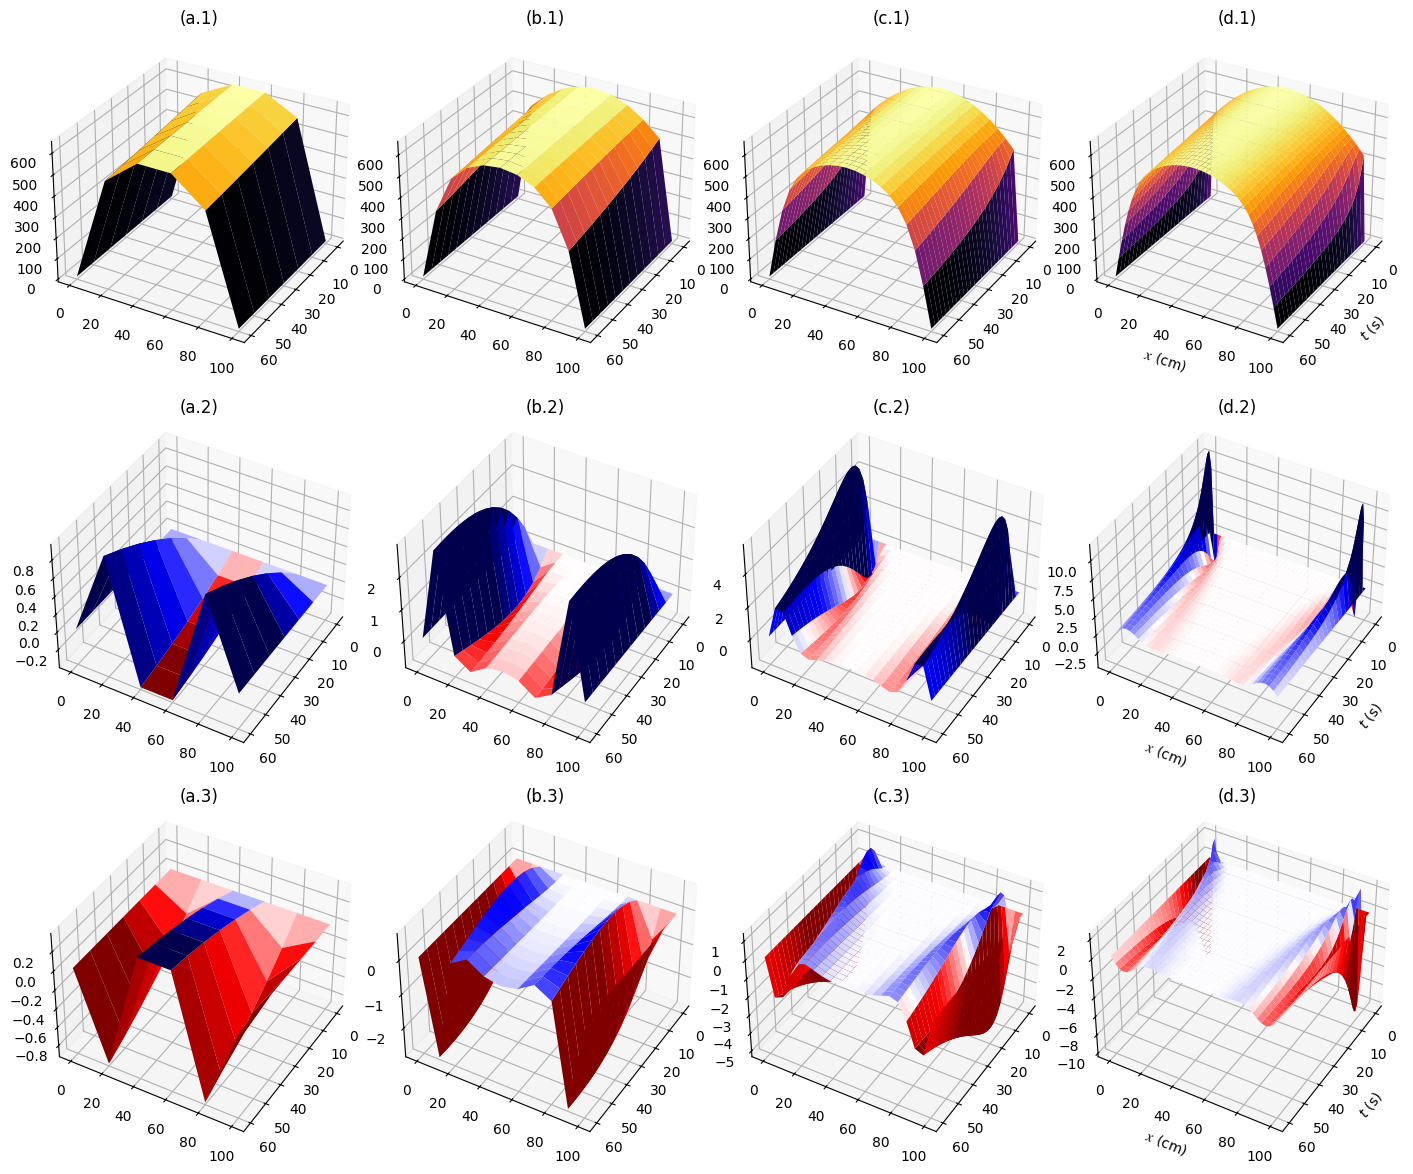

In [9]:
def _3d_plot1(ax, X, T, T_xt, zlabel="", title="", show_cbar=False, **kwargs):
	if "linewidth" not in kwargs:
		kwargs["linewidth"] = 0.0
	
	ax.spines["top"].set_visible(False)
	ax.spines["bottom"].set_visible(False)
	ax.spines["left"].set_visible(False)
	ax.spines["right"].set_visible(False)
	
	surf = ax.plot_surface(T, X, T_xt, antialiased=True, edgecolor='black', **kwargs)
	ax.set_title(title)
	if show_cbar:
		ax.set_ylabel(r'$𝑥\ $(cm)')
		ax.set_xlabel(r'$t\ $(s)')
		# ax.set_zlabel(zlabel)
	return ax, surf

def p3_3d_fd_cn_combined(dxs, dts, fig_path=None):
	# Assuming 4 pairs of dx and dt values for 4 different plots per row
	fig, axs = plt.subplots(3, len(dxs), figsize=(3.5 * len(dxs), 12), subplot_kw={"projection": "3d"})
	
	for i, (dx, dt) in enumerate(zip(dxs, dts)):
		# First row plots (Crank-Nicolson results)
		g, c = 0.1, 400.0
		hs = HeatSolver(dx=dx, dt=dt, t_total=60)
		hs.T_x0 = lambda x: -x * g * (x - hs.L) + c

		T_cn = hs.solve_crank_nicholson()
		ts, xs = np.meshgrid(hs.ts, hs.xs)

		ax1 = axs[0, i]
		_3d_plot1(ax1, xs, ts, T_cn.T, zlabel=r"$T\ (^\circ C)$", title=f"({chr(ord('a')+i)}.1)", show_cbar=i==len(dxs)-1, cmap=cm.inferno)
		ax1.view_init(30, 30)
		
		T_fd = hs.solve_finite_distance()
		D = T_cn - T_fd
	
		ax2 = axs[1, i]
		vmax = max(abs(D.min()), abs(D.max())) / 3
		_3d_plot1(ax2, xs, ts, D.T, cmap=cm.seismic_r, zlabel="FTCS Difference ", title=f"({chr(ord('a')+i)}.2)", show_cbar=i==len(dxs)-1, vmin=-vmax, vmax=vmax)
		ax2.view_init(40, 30)

		T_bd = hs.solve_backward_distance()
		D = T_cn - T_bd
	
		ax3 = axs[2, i]
		vmax = max(abs(D.min()), abs(D.max())) / 3
		_3d_plot1(ax3, xs, ts, D.T, cmap=cm.seismic_r, zlabel="BTCS Difference", title=f"({chr(ord('a')+i)}.3)", show_cbar=i==len(dxs)-1, vmin=-vmax, vmax=vmax)
		ax3.view_init(40, 30)


	plt.tight_layout()
	if fig_path:
		fig.savefig(fig_path)

dxs = [20, 10, 5, 2.5]
dts = [10, 5, 2.4, 1.2]
p3_3d_fd_cn_combined(dxs, dts, fig_path="figs/p3_c.svg")

6.354271686678467
4.305727918698489
2.0705597805756066
0.8261946193373426


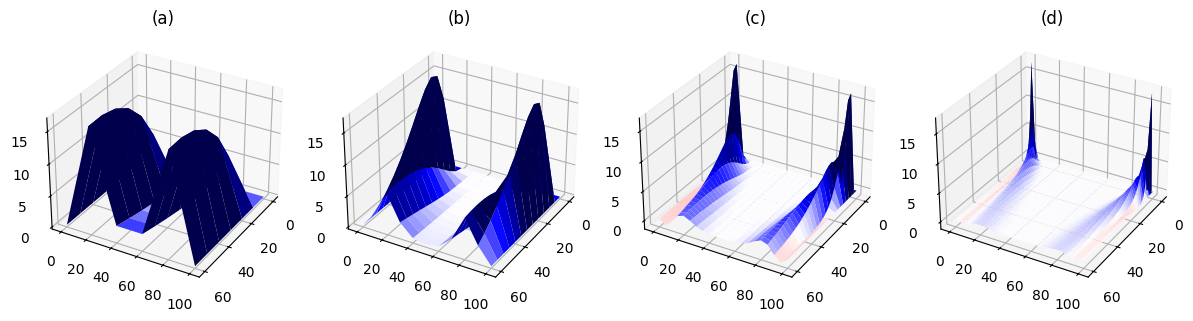

In [83]:
def p3_3d_fd_cn_combined(dxs, dts, fig_path=None):
	# Assuming 4 pairs of dx and dt values for 4 different plots per row
	fig, axs = plt.subplots(1, len(dxs), figsize=(3 * len(dxs), 3), subplot_kw={"projection": "3d"})
	
	for i, (dx, dt) in enumerate(zip(dxs, dts)):
		# First row plots (Crank-Nicolson results)
		g, c = 0.1, 400.0
		hs = HeatSolver(dx=dx, dt=dt, t_total=60)
		hs.T_x0 = lambda x: -x * g * (x - hs.L) + c
		
		T = hs.solve_crank_nicholson()
		hs.dx = dx * 2
		hs.dt = dt * 2
		Tp = hs.solve_crank_nicholson()
		ts, xs = np.meshgrid(hs.ts, hs.xs)
		
		D = T[::2,::2] - Tp
		Di = T[::2**(i+1), ::2**(i+1)] - Tp[::2**i, ::2**i]

		# print(f"Δx = {dx}cm, Δt = {dt}s:")
		print(f"{np.std(D)}")
		# print(f" with {D.shape}: {np.mean(D)} ± {np.std(D)}, {np.median(D)}")
		# print(f" with {Di.shape}: {np.mean(Di)} ± {np.std(Di)}, {np.median(Di)}")
		
		vmax = max(abs(D.min()), abs(D.max())) / 3
		_3d_plot1(axs[i], xs, ts, D.T, cmap=cm.seismic_r, title=f"({chr(ord('a')+i)})",zlabel="Difference", vmin=-vmax, vmax=vmax)
		axs[i].view_init(30,30)


	plt.tight_layout()
	if fig_path:
		fig.savefig(fig_path)

dts = [5, 2.5, 1.25, 0.625]
dxs = [10, 5, 2.5, 1.25]	

p3_3d_fd_cn_combined(dxs, dts, fig_path="figs/p3_d.svg")

In [81]:
t_total = 60

def calculate_dt(dx):
	return dx**2 / (10 * k)

def adjust_dt_for_t_total(dt_max):
	for divisor in range(1, int(t_total) * 10 + 1):
		dt_candidate = t_total / divisor
		if dt_candidate <= dt_max:
			return dt_candidate

dx_values = [10, 5, 2.5, 1.25]	
dt_values = [adjust_dt_for_t_total(calculate_dt(dx)) for dx in dx_values]

print(dx_values)
print(dt_values)

[10, 5, 2.5, 1.25]
[10.0, 2.857142857142857, 0.7142857142857143, 0.17857142857142858]


0.026527773822767328
0.10648240601575769
0.025576020324270678
0.17788685896185938
0.01593238793384321
0.2498900506535687


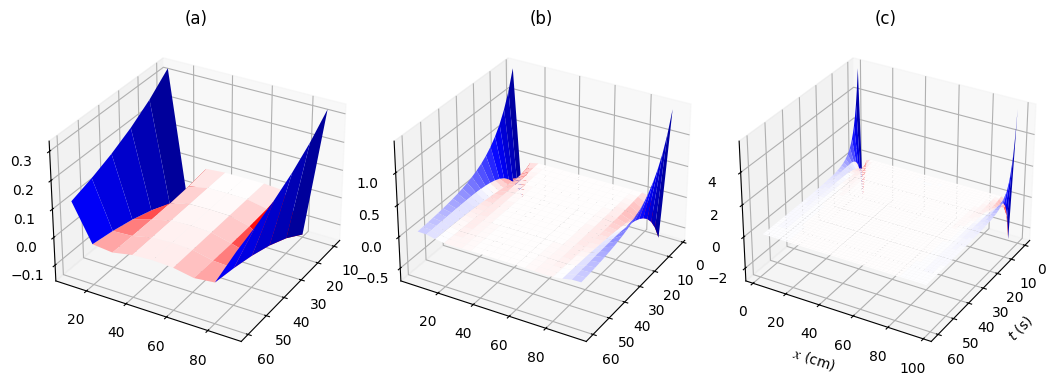

In [74]:
def p3_3d_fd_cn_defect(dxs, dts, fig_path=None):
	# Assuming 4 pairs of dx and dt values for 4 different plots per row
	fig, axs = plt.subplots(1, len(dxs), figsize=(3.5 * len(dxs), 4), subplot_kw={"projection": "3d"})
	
	for i, (dx, dt) in enumerate(zip(dxs, dts)):
		# First row plots (Crank-Nicolson results)
		g, c = 0.1, 400.0
		hs = HeatSolver(dx=dx, dt=dt, t_total=60)
		hs.T_x0 = lambda x: -x * g * (x - hs.L) + c

		T = hs.solve_crank_nicholson()
		ts, xs = np.meshgrid(hs.ts[1:], hs.xs[1:-1])

		T_dx2 = (T[:,2:] - 2*T[:,1:-1] + T[:,:-2]) / dx**2 # i=1..=I-1 j=0..=J
		T_dt = (T[1:,:] - T[:-1,:]) / dt # i=0..=I j=1..=J
		T_dx2 = T_dx2[1:,]
		T_dt = T_dt[:,1:-1]
		
		D_cn = T_dx2 - T_dt / hs.k
		print(f"{np.mean(D_cn)}")
		print(f"{np.std(D_cn)}")
		

		vmax = max(abs(D_cn.min()), abs(D_cn.max())) / 3
		_3d_plot1(axs[i], xs, ts, D_cn.T, cmap=cm.seismic_r, title=f"({chr(ord('a')+i)})",zlabel="Difference", show_cbar=i==len(dxs)-1, vmin=-vmax, vmax=vmax, linewidth=0.0)
		axs[i].view_init(30, 30)

	plt.tight_layout()
	if fig_path:
		fig.savefig(fig_path)

dxs = [10.0, 5.0, 2.5]
dts = [10.0, 2.857142857142857, 0.7142857142857143]

p3_3d_fd_cn_defect(dxs, dts, fig_path="figs/p3_e.svg")